# Packages

In [1]:
#%cd /content/drive/MyDrive/MscThesis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import pandas as pd
import time
import gwpy
import nds2 # conda config --add channels conda-forge \n conda install python-nds2-client
import numba

from gwpy.table import EventTable
from gwpy.table import GravitySpyTable
from gwpy.detector import ChannelList, Channel
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries #if this does not work, remove h5py and reinstall h5py
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import vstack
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [2]:
current_dir = %pwd

In [3]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
#train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
#val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
#test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

In [4]:
# Extract glitches and IFO ---> ONLY ONCE
L1_filename = "L1_glitches.txt"
H1_filename = "H1_glitches.txt"

glitch_names_L1 = set()
glitch_names_H1 = set()

for root, _, files in os.walk(train_dir):
    for filename in files:
        if filename.startswith("H1_"):
            parts = filename.split("_")
            if len(parts) >= 3:
                glitch_names_H1.add(parts[1])
        if filename.startswith("L1_"):
            parts = filename.split("_")
            if len(parts) >=2:
                glitch_names_L1.add(parts[1])

with open(os.path.join(current_dir, L1_filename), "w") as output_file:
    for name in glitch_names_L1:
        output_file.write(f"{name}\n")
        
with open(os.path.join(current_dir, H1_filename), "w") as output_file:
    for name in glitch_names_H1:
        output_file.write(f"{name}\n")

In [5]:
filenames = []
with open("H1_glitches.txt", "r") as file:
    for line in file:
        filenames.append(line.strip())

In [6]:
# Set the environment variables
os.environ["GRAVITYSPY_DATABASE_USER"] = "mla"
os.environ["GRAVITYSPY_DATABASE_PASSWD"] = "gl1tch35Rb4d!"
glitch_labels = ['1400Ripples', '1080Lines', 'Air_Compressor', 
                 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 
                 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 
                 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 
                 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']
O3b_start = 1256655618
O3b_stop = 1269363618

In [7]:
O3b_csv = pd.read_csv('Data/data_o3b_high_confidence.csv')

In [8]:
glitch_id = 'M09XzQgn81'

In [9]:
glitch_start_time = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])-2
glitch_stop_time = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])+2

In [10]:
step = 0.25
sampling_rate = 16384
#sampling_rate = 512
decimate = 64
#channel = 'L1:DCS-CALIB_STRAIN_C01_AR'
channel = 'H1:DCS-CALIB_STRAIN_C01_AR'
#channel = 'L1:PEM-EY_MIC_VEA_PLUSY_DQ'
#channel = 'L1:LSC-PRCL_IN1_DQ'
#channel = 'L1:LSC-PRCL_OUT_DQ'
#channel = 'L1:ASC-CHARD_Y_OUT_DQ'
server = 'losc-nds.ligo.org'
#server = 'nds.gwosc.org'
alpha = 1
data_end = sampling_rate * (glitch_stop_time - glitch_start_time)
data = pd.DataFrame(columns=['time', 'value'])
data_length = int((glitch_stop_time - glitch_start_time) / step)

In [11]:
chanList = ChannelList.query_nds2('*', host=server)
print("Found {0} channels\n".format(len(chanList)))
print("Printing first 10 channels ...")
auxlist = [chan for chan in chanList if 'H1:DCS-CALIB' in chan.name]
print("Here are channels containing L1 in the name ...")
for chan in auxlist:
    print(chan.name, chan.sample_rate)

Found 1294 channels

Printing first 10 channels ...
Here are channels containing L1 in the name ...
H1:DCS-CALIB_STRAIN_C01_AR 16384.0 Hz
H1:DCS-CALIB_STRAIN_CLEAN_C01_AR 16384.0 Hz
H1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01_AR 16384.0 Hz


In [12]:
data_conditioned = my_gwpy_and_fractals.fetch_and_whiten_data(glitch_start_time, glitch_stop_time, server, sampling_rate, channel)

Getting the TimeSeries data
fetch_and_whiten_data: 20534.483671188354 ms


In [13]:
data_conditioned

array([ 0.419729  , -0.11960886, -0.66500293, ...,  0.41686931,
       -1.42837722,  1.4228901 ])

In [14]:
time_stamps = np.arange(0, int(data_end/2))
time_stamps_array = np.split(time_stamps, data_length)
for element in time_stamps_array:
    try:
        data = pd.concat([data, pd.DataFrame(pd.Series([element, data_conditioned[element]], index=['time', 'value'])).T], ignore_index=True)
    except:
        print('No data or exception')
        pass

In [15]:
len(data_conditioned)

32768

In [16]:
number_of_chunks = data_length
data_fd = pd.DataFrame(columns=['time', 'fd'])

for chunk in range(0, number_of_chunks):
    start_chunktime = chunk * step + glitch_start_time
    check_valid = data.iloc[chunk].value
    if np.isnan(check_valid.all()):
        print(f"Warning, undefined data, FD is set to zero at time {start_chunktime}.")
        continue
    print(f"Computing the var estimator for data starting at {start_chunktime} time.")
    #print(data.iloc[chunk])
    est_eval = my_gwpy_and_fractals.var_function(data.iloc[chunk], decimate)
    est_fit = my_gwpy_and_fractals.fit_est(est_eval, sampling_rate)
    fractal_dimension = 2.-est_fit[3]
    print(f"fd= {fractal_dimension}")
    data_fd = pd.concat([data_fd, pd.DataFrame([[start_chunktime, fractal_dimension]], columns=['time', 'fd'])], ignore_index=True) 

Computing the var estimator for data starting at 1258107541.0 time.
var_function: 2020.4203128814697 ms
fit_est: 15.969038009643555 ms
fd= 1.6964179745628898
Computing the var estimator for data starting at 1258107541.25 time.
var_function: 2.025604248046875 ms
fit_est: 0.9362697601318359 ms
fd= 1.6910193885639806
Computing the var estimator for data starting at 1258107541.5 time.
var_function: 1.0290145874023438 ms
fit_est: 2.3355484008789062 ms
fd= 1.7021072681083431
Computing the var estimator for data starting at 1258107541.75 time.
var_function: 1.0340213775634766 ms
fit_est: 2.31170654296875 ms
fd= 1.6988379351815883
Computing the var estimator for data starting at 1258107542.0 time.
var_function: 1.0306835174560547 ms
fit_est: 1.9402503967285156 ms
fd= 1.6865333580866158
Computing the var estimator for data starting at 1258107542.25 time.
var_function: 1.0297298431396484 ms
fit_est: 1.9330978393554688 ms
fd= 1.6827166503443263
Computing the var estimator for data starting at 125

In [17]:
filename = "FD_data/fd_calculation_" + glitch_id + "_aux_channel_" + channel.replace(':', '_') + ".txt"
data_fd.to_csv(filename, sep='\t', index=False)

<ErrorbarContainer object of 3 artists>

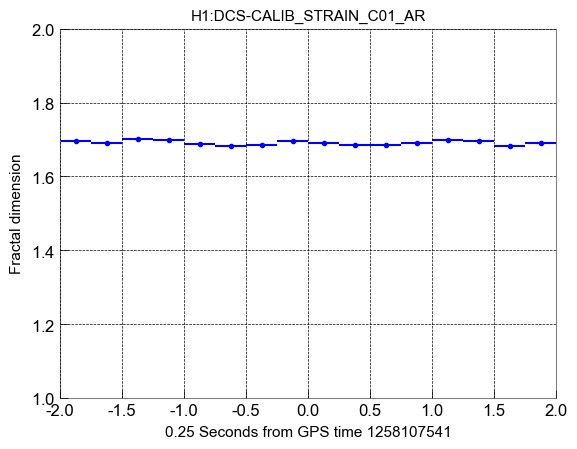

In [18]:
fig, ax = plt.subplots()
plot_min_y = 1.0
plot_max_y = 2.0

ax.set_title(channel, fontsize=11)
ax.tick_params(direction='in', length=6, width=0.5, colors='black', grid_color='r', grid_alpha=1)
ax.set_xlabel(f"{step} Seconds from GPS time {glitch_start_time}", fontsize=11)
ax.set_ylabel("Fractal dimension",fontsize=11)
ax.set_xlim([glitch_start_time,glitch_stop_time])
ax.set_ylim([plot_min_y, plot_max_y])
ax.set_xticks(np.linspace(glitch_start_time, glitch_stop_time, 9))
ax.set_xticklabels(np.linspace(-2, 2, 9))

ax.grid(which='both', axis='both', linestyle='--', color='k', linewidth=0.5)

time = data_fd['time'].values
step = time[1]-time[0]
fd = data_fd['fd'].values
ax.errorbar(time+step/2, fd, xerr=step/2, fmt='.', c='b')

## Calculate FD for all glitches in train_dir (H1 and L1)

In [19]:
filenames = []
with open("H1_glitches.txt", "r") as file:
    for line in file:
        filenames.append(line.strip())

In [20]:
def is_in_interval(number, interval_dataframe):
  """
  This function checks if a number falls within any of the intervals in a DataFrame.

  Args:
      number: The number to check.
      interval_dataframe: A DataFrame with two columns, 'start' and 'stop', representing the intervals.

  Returns:
      A boolean value indicating whether the number falls within any interval (True) or not (False).
  """
  return (interval_dataframe[0] <= number) & (number <= interval_dataframe[1]).any()

In [21]:
glitch_segments_H1 = []
gsH1 = pd.read_csv("Data/H1-SEGS-AUX_CLN.csv", header=None)

In [ ]:
for fn in filenames:
    glitch_id = str(fn)
    peak_time = O3b_csv[O3b_csv.id == glitch_id]['GPStime']
    if not peak_time.empty:
        start = int(peak_time)-2
        tmp1 = is_in_interval(start, gsH1)
        if tmp1.any():
            stop = int(peak_time)+2
            tmp2 = is_in_interval(stop, gsH1)
            if tmp2.any():
                print(f"FD calculation for {glitch_id} has started.")
                data_fd = my_gwpy_and_fractals.calculate_fd_files(start, stop, server, sampling_rate, channel, step, decimate, alpha, False)
                filename = "FD_data/fd_calculation_" + glitch_id + "_aux_channel_" + channel.replace(':', '_') + ".txt"
                data_fd.to_csv(filename, sep='\t', index=False)
            else:
                print(f"{stop} does not fall within any of the intervals")
        else:
          print(f"{start} does not fall within any of the intervals")
    else:
        print(f"Error with the glitch labeled {glitch_id}")

Error with the glitch labeled h79UFCfoVS
FD calculation for HeqG1nXOif has started.
Getting the TimeSeries data
fetch_and_whiten_data: 13720.151901245117 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 2.950906753540039 ms
fit_est: 0.9951591491699219 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 12.502193450927734 ms
fit_est: 0.32520294189453125 ms
var_function: 1.9693374633789062 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 4.529237747192383 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 0.0 ms
fit_est: 0.0 ms
var_function: 14.127016067504883 ms
fit_est: 0.9975433349609375 ms
calculate_fd_files: 13814.737319946289 ms
Error with the glitch labeled 8EFqRMDol7
FD calculation for fh25j0JZXv has started.
Gettin